In [2]:
import os
import cv2
from matplotlib import pyplot as plt


In [3]:
os.chdir("c:\\Users\\smatysik\\projects\\nvimagecodec\\build\\example\\example_decode\\RelWithDebInfo")
#os.chdir("/mnt/c/Users/smatysik/projects/nvImageCodecsWSL2/build/example/example_decode")


# OpenCV

Load small image with OpenCV

In [4]:
%%time 
cv_img_cat = cv2.imread("cat.j2k")


CPU times: total: 31.2 ms
Wall time: 35.3 ms


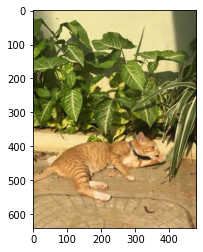

In [5]:
cv_img_cat = cv2.cvtColor(cv_img_cat, cv2.COLOR_BGR2RGB)
plt.imshow(cv_img_cat)

Load 4k image with OpenCV

In [6]:
%%time 
#%%timeit -r 1 -n 10
cv_img_4k = cv2.imread("4k_lossless.jp2")


CPU times: total: 1.64 s
Wall time: 1.64 s


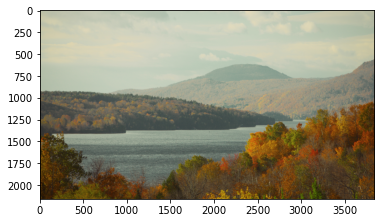

In [7]:
cv_img_4k = cv2.cvtColor(cv_img_4k, cv2.COLOR_BGR2RGB)
plt.imshow(cv_img_4k)


# nvImageCodecs

In [8]:
import nvimgcodecs

Load small Jpeg2000 image with nvImageCodecs

In [9]:
%%time
#%%timeit -r 5 -n 10
nv_img_cat = nvimgcodecs.imread("cat.j2k")


CPU times: total: 266 ms
Wall time: 366 ms


Load 4k Jpeg2000 (in jp2 container) image with nvImageCodecs

In [10]:
%%time
#%%timeit -r 5 -n 10
nv_img4k = nvimgcodecs.imread("4k_lossless.jp2")

CPU times: total: 250 ms
Wall time: 260 ms


Save 4k image to bmp file with nvImageCodecs

In [11]:
%%time
#%%timeit -r 1 -n 10
nvimgcodecs.imwrite("4k_lossless.bmp", nv_img4k)


CPU times: total: 609 ms
Wall time: 628 ms


Read back with OpenCV just save (with nvImageCodecs) bmp image 

In [12]:
cv_img_4k_bmp = cv2.imread("4k_lossless.bmp")


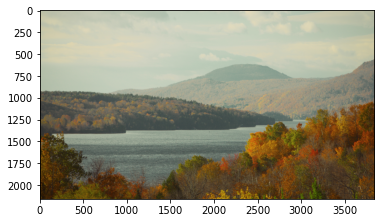

In [13]:
cv_img_4k_bmp = cv2.cvtColor(cv_img_4k_bmp, cv2.COLOR_BGR2RGB)
plt.imshow(cv_img_4k_bmp)


Save as Jpeg 2000

In [14]:
%%time
# %%timeit -r 1 -n 10
nvimgcodecs.imwrite("new_4k_lossless.j2k", nv_img4k)


CPU times: total: 406 ms
Wall time: 404 ms


## nvImageCodes Image  __cuda_array_interface__ support

In [15]:
print(nv_img4k.__cuda_array_interface__)
print(nv_img4k.shape)


{'shape': (2160, 3840, 3), 'strides': (4096, 1, 8847360), 'typestr': '=B', 'data': (34407972864, False), 'version': 2}
(2160, 3840, 3)


Lets test it with cupy

In [16]:

import cupy as cp

Convert to Numpy (CPU) array

In [17]:

np_img4k = cp.asnumpy(nv_img4k)



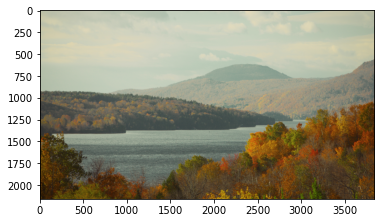

In [18]:
plt.imshow(np_img4k)

Convert tp cupy ndarray

In [19]:
%%time
cp_img4k = cp.asarray(nv_img4k)


CPU times: total: 0 ns
Wall time: 25.5 µs


Lets do some opration on image in GPU using cupyx.scipy

In [20]:
import cupyx.scipy.ndimage


In [21]:

cp_img_4k_rotated = cupyx.scipy.ndimage.rotate(cp_img4k, 90)
cp_img_4k_gaussian = cupyx.scipy.ndimage.gaussian_filter(cp_img4k, sigma = 15)
cp_img_4k_laplace = cupyx.scipy.ndimage.laplace(cp_img4k)
cp_img_4k_single_channel = cp_img4k[:, :, 1]


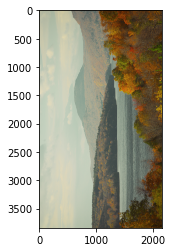

In [22]:
np_img_4k = cp.asnumpy(cp_img_4k_rotated)
plt.imshow(np_img_4k)


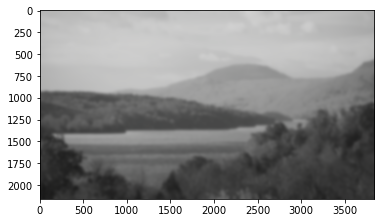

In [23]:
np_img_4k = cp.asnumpy(cp_img_4k_gaussian)
plt.imshow(np_img_4k)


Save rotated version which is in cupy ndarray format (GPU) to file using nvImageCodecs 

In [24]:
nv_rotated_img = nvimgcodecs.asimage(cp_img_4k_rotated)


In [25]:
%%time
nvimgcodecs.imwrite("rotated.bmp", nv_rotated_img)


CPU times: total: 625 ms
Wall time: 637 ms


Read and show saved rotaed image to verify

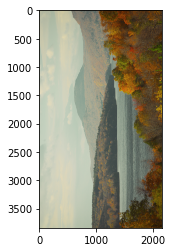

In [26]:
cv_img_4k_bmp = cv2.imread("rotated.bmp")
cv_img_4k_bmp = cv2.cvtColor(cv_img_4k_bmp, cv2.COLOR_BGR2RGB)
plt.imshow(cv_img_4k_bmp)


Save as JPEG2000

nvJpeg2000 now supports only Planar RGB and cupy ndarray is in interleaved RGB order so we need to convert it before providing buffer to nvJpeg2000. In future nvJpeg2000 should probably support I_RGB.

In [27]:
%%time
cp_img_4k_rotated_planar = cp.moveaxis(cp_img_4k_rotated, (0, 1), (1, 0))
cp_img_4k_rotated_planar = cp.asfortranarray(cp_img_4k_rotated_planar)
cp_img_4k_rotated_planar = cp.moveaxis(cp_img_4k_rotated_planar, (0,1), (1,0))



CPU times: total: 0 ns
Wall time: 990 µs


In [28]:
%%time
nv_rotated_img = nvimgcodecs.asimage(cp_img_4k_rotated_planar)


CPU times: total: 0 ns
Wall time: 0 ns


In [29]:
%%time
nvimgcodecs.imwrite("rotated.j2k", nv_rotated_img)


CPU times: total: 562 ms
Wall time: 587 ms


Interoperability with cuCIM (only Linux)

In [30]:
# Image source https: // idr.openmicroscopy.org/
#image = cv2.imread('https://idr.openmicroscopy.org/webclient/render_image_download/9844404/?format=tif')
#cv2.imwrite("medical.j2k", image)


In [31]:
from cucim.skimage.filters import gaussian


ModuleNotFoundError: No module named 'cucim'

In [ ]:
cp_img4k_blurred = gaussian(cp_img_4k_single_channel, sigma=5)
cp_img4k_blurred_color = gaussian(nv_img4k, sigma=25)
image = cp.asnumpy(cp_img4k_blurred)
plt.imshow(image, cmap='gray')


In [ ]:
from cucim.skimage.filters import threshold_otsu
# determine threshold
threshold = threshold_otsu(cp_img4k_blurred)

# binarize image by apply the threshold
cp_binary_gpu = cp_img4k_blurred > threshold

image = cp.asnumpy(cp_binary_gpu)
plt.imshow(image, cmap='gray')


In [ ]:
from cucim.skimage.morphology import binary_erosion, disk

eroded_gpu = binary_erosion(cp_binary_gpu, selem=disk(2))
image = cp.asnumpy(eroded_gpu)
plt.imshow(image, cmap='gray')


In [ ]:
print(cp_img4k_blurred_color.__cuda_array_interface__)

In [ ]:
%%time
cp_img_planar = cp.moveaxis(cp_img4k_blurred_color, (0, 1), (1, 0))
cp_img_planar = cp.asfortranarray(cp_img_planar)
cp_img_planar = cp.moveaxis(cp_img_planar, (0, 1), (1, 0))
nv_img = nvimgcodecs.asimage(cp_img_planar)


In [ ]:
%%time
nvimgcodecs.imwrite("blurred.j2k", nv_img)
